<a href="https://colab.research.google.com/github/MananShukla7/SkimLit/blob/main/skimlit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Project : SkimLit📝🔥

`Short for Skimming Literature`

The purpose of this notebook is to build a NLP model to make reading medical abstracts
a lot easier

The Dataset that we are using is PubMed 200k RCT and the paper we are replicating is :
https://arxiv.org/abs/1710.06071



##Confirming access to GPU

In [1]:
!nvidia-smi

Sat Jun 10 14:42:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##Getting Data

Downloading the dataset from the paper's author: https://github.com/Franck-Dernoncourt/pubmed-rct

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 14.20 MiB/s, done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
#Check what filer are in the PubMed 20k dataset
!ls /content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [4]:
#Start our experiments by exploring and experimenting on 20k dataset!
data_dir="/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign"

In [5]:
#Check all of the filename of its directory
import os
filenames=[data_dir+"/"+filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

##Data Preprocessing

Now we've got some text data, now we have to explore it throughly.

To do that we need to visualise it first.

In [6]:
#Reading the files with python

def get_lines(filename):
  """
  Reads the filename (a text filename) and returns all of the lines of the text file
  as a list.

  Args:
  filname: a string containing the target filepath

  Returns:
  A list of string with one string per line from the input text line
  """
  f=open(filename,"r")
  return f.readlines()



In [7]:
# Let's read into the training lines
train_dir=filenames[1]
train_lines=get_lines(train_dir)
train_lines[:20]

['###24845963\n',
 'BACKGROUND\tThis study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .\n',
 'RESULTS\tA post hoc analysis was conducted with the use of data from the Evaluation Study of Congestive Heart Failure and Pulmonary Artery Catheterization Effectiveness ( ESCAPE ) .\n',
 'RESULTS\tLiver function tests ( LFTs ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .\n',
 'RESULTS\tSurvival analyses were used to assess the association between admission Model of End-Stage Liver Disease Excluding International Normalized Ratio ( MELD-XI ) scores and patient outcome.There was a high prevalence of abnormal baseline ( admission ) LFTs ( albumin @ % , aspartate transaminase @ % , alanine transaminase @ % , and total bilirubin @ % ) .\n',
 "RESULTS\tThe percentage of patients with abnormal LFTs decreased significantly from baseline to @-months ' follow-up .\n",
 'RE

In [8]:
len(train_lines)

35135

###Data Structuring

Representing this data into dictionaries as it is easily manipulated.

A sample structure would look like:

```[{'line_number' : 0,
   'target' : 'BACKGROUND',
   'text' : 'Emotional eating is associated with overeating and the development of obesity .\n',
   'total_lines' : 11, 
   ...
   }]```

In [9]:
# def preprocess_text_with_line_num(filename):
#   types=["BACKGROUND", "OBJECTIVE", "METHODS", "RESULTS", "CONCLUSION"]
#   list1=[]
#   txtData=get_lines(filename)
#   linecount=0
#   for txt in txtData:
   
#     if txt.startswith("###"):
#         linecount=0
#         start_index=txtData.index(txt)
#         end_index=txtData.index("\n",start_index)
#         total_lines=end_index-start_index
#         # dict.update()
    
#     elif txt.isspace():

#       continue

#     else:

#       # for typ in types:
#       #   if typ in txt:
#       #     target=typ
#       target="abc"


#       start=txt.find("\t")
#       end=txt.find(".\n")
#       text=txt[start+1:end+1]
            
      
#       data={}
#       data["line_number"]=linecount
#       data["target"]=target
#       data["text"]=text
#       data["total_line"]=total_lines
#       # print(target.dtype)
#       list1.append(data)
#       linecount+=1
#       # print(f"[line_number:{linecount},\ntarget:{target},\ntext:{text},\ntotal_line:{total_lines}]\n\n")
#   return list1
  




  
    
    

In [10]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [11]:
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

In [12]:
%%time
train_samples=preprocess_text_with_line_numbers(filenames[1])
val_samples=preprocess_text_with_line_numbers(filenames[0])
test_samples=preprocess_text_with_line_numbers(filenames[2])


CPU times: user 332 ms, sys: 68.3 ms, total: 401 ms
Wall time: 410 ms


In [13]:
str1="###35279E"
x="###" in str1
x

True

In [14]:
l1=["BAKCGROUND","obj\n","\n"]
str2="BAKCGROUND \n ribdiuabda oddnaoid.\n"
for i in l1:
  print(i)
  if i in str2:
    x=i
s=str2.find("KC")
x,s

BAKCGROUND
obj





('\n', 2)

In [15]:
str2[0:2]

'BA'

In [16]:
l1.index("\n")

2

In [17]:
td="""Recreate the above func of greater efficiency """

##Data Analysis
Now that our data is in the format of dictionaries ,we can turn it into the df to
visualize it much better

In [18]:
import pandas as pd
train_df=pd.DataFrame(train_samples)
val_df=pd.DataFrame(val_samples)
test_df=pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8
1,RESULTS,a post hoc analysis was conducted with the use...,1,8
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8
3,RESULTS,survival analyses were used to assess the asso...,3,8
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8
6,RESULTS,multivariable analyses revealed that patients ...,6,8
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12


In [19]:
#DIstribution of labels in training labels
distrib=train_df.target.value_counts()
distrib


METHODS        9897
RESULTS        9713
CONCLUSIONS    4571
BACKGROUND     3621
OBJECTIVE      2333
Name: target, dtype: int64

<BarContainer object of 5 artists>

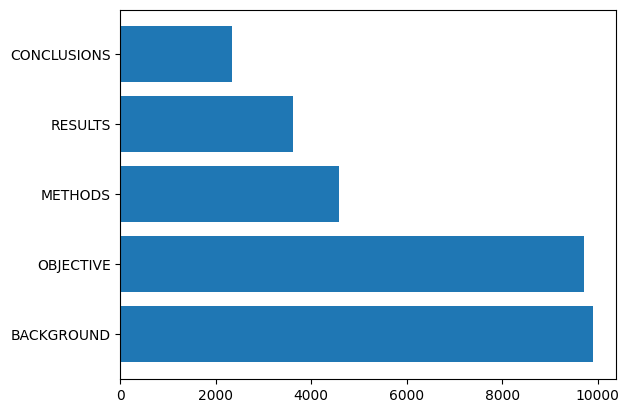

In [20]:
import matplotlib.pyplot as plt

plt.barh(val_df.target.unique(),distrib)

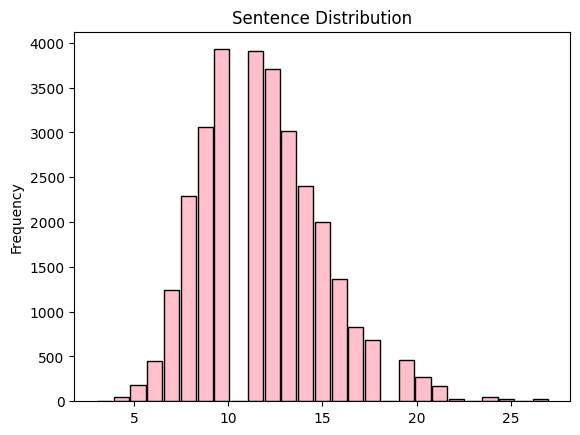

In [21]:
#Check length of different lines

# plt.bar(range(0,train_df.total_lines.value_counts().max()),train_df.total_lines.value_counts())
train_df.total_lines.plot(kind="hist",bins=27,rwidth=0.9,edgecolor="black",color="pink",xlabel="Number of sentences per abstract",title="Sentence Distribution");

In [22]:
(train_df.total_lines.value_counts())

10    3927
11    3912
12    3705
9     3060
13    3010
14    2400
8     2286
15    2000
16    1360
7     1240
17     828
18     684
19     460
6      448
20     273
5      186
21     176
24      50
4       45
27      28
25      26
22      23
3        8
Name: total_lines, dtype: int64

###Get the list of the sentences


In [23]:
#Convert abstract text into lists
train_sentences=train_df["text"].tolist()
val_sentences=val_df["text"].tolist()
test_sentences=test_df["text"].tolist()
len(train_sentences),len(val_sentences),len(test_sentences)

(30135, 30212, 180040)

In [24]:
train_labels=train_df["target"].tolist()
val_labels=val_df["target"].tolist()
test_labels=test_df["target"].tolist()
len(train_labels),len(val_labels),len(test_labels)

(30135, 30212, 180040)

In [25]:
#View the first 10 lines of the training sentences
train_sentences[:10],train_labels[:10]

(['this study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( adhf ) .',
  'a post hoc analysis was conducted with the use of data from the evaluation study of congestive heart failure and pulmonary artery catheterization effectiveness ( escape ) .',
  'liver function tests ( lfts ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .',
  'survival analyses were used to assess the association between admission model of end-stage liver disease excluding international normalized ratio ( meld-xi ) scores and patient outcome.there was a high prevalence of abnormal baseline ( admission ) lfts ( albumin @ % , aspartate transaminase @ % , alanine transaminase @ % , and total bilirubin @ % ) .',
  "the percentage of patients with abnormal lfts decreased significantly from baseline to @-months ' follow-up .",
  'when mean hemodynamic profiles were compared in patients with abnormal v

##Making the numeric labels(for ml model)

###One hot encoder

In [26]:
# !pip install category_encoders -q
# import category_encoders as ce
# one_hot_encoded_lables=ce.OneHotEncoder(val_df.target.unique())


Using the get_dummies for now...

In [27]:
%%time
train_encoded_onehot=pd.get_dummies(train_df.target).to_numpy()
val_encoded_onehot=pd.get_dummies(val_df.target).to_numpy()
test_encoded_onehot=pd.get_dummies(test_df.target).to_numpy()

CPU times: user 36.7 ms, sys: 1.95 ms, total: 38.6 ms
Wall time: 51.6 ms


In [28]:
from sklearn.preprocessing import OneHotEncoder
encoder=OneHotEncoder(sparse=False)#tf doesnt support sparse matrix


In [29]:
%%time
train_one_hot=encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
train_one_hot

CPU times: user 15.1 ms, sys: 2.02 ms, total: 17.2 ms
Wall time: 27.1 ms


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.]])

#####**Result**: get_dummies is a bit faster then one_hot(sklearn) [will see difference in the 200k dataset]

In [30]:
train_df.target[:5]

0    BACKGROUND
1       RESULTS
2       RESULTS
3       RESULTS
4       RESULTS
Name: target, dtype: object

###Label encode labels



####Manual labelling

In [31]:
#Creating a Dictionary of target labels
target_labels={label:target for label,target in enumerate(val_df.target.unique())}
target_labels

{0: 'BACKGROUND', 1: 'OBJECTIVE', 2: 'METHODS', 3: 'RESULTS', 4: 'CONCLUSIONS'}

In [32]:
#get class names
class_names=val_df.target.unique()
class_names

array(['BACKGROUND', 'OBJECTIVE', 'METHODS', 'RESULTS', 'CONCLUSIONS'],
      dtype=object)

In [33]:
test=train_df.replace(train_df.target.unique(),range(0,len(train_df.target.unique())))
test[:5]

,target,text,line_number,total_lines
0,0,this study analyzed liver function abnormaliti...,0,8
1,1,a post hoc analysis was conducted with the use...,1,8
2,1,liver function tests ( lfts ) were measured at...,2,8
3,1,survival analyses were used to assess the asso...,3,8
4,1,the percentage of patients with abnormal lfts ...,4,8


####Using Sklearn here

In [34]:
from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()
train_labels_encoded=label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded=label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded=label_encoder.transform(test_df["target"].to_numpy())

#check what the training label look like

train_labels_encoded[:5],train_labels_encoded.shape

(array([0, 4, 4, 4, 4]), (30135,))

In [35]:
class_names[train_labels_encoded[:5]]

array(['BACKGROUND', 'CONCLUSIONS', 'CONCLUSIONS', 'CONCLUSIONS',
       'CONCLUSIONS'], dtype=object)

###Model 0(Bayes Classification): The baseline

In [36]:
#importing libraries
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [37]:
tf_vectorizer=CountVectorizer()
vectorized_sentences=tf_vectorizer.fit_transform(train_sentences)
vectorized_val_sentences=tf_vectorizer.transform(val_sentences)

In [38]:
len(train_sentences),vectorized_sentences.data

(30135, array([1, 1, 1, ..., 1, 1, 1]))

In [39]:
vectorized_val_sentences.shape,vectorized_sentences.shape

((30212, 20341), (30135, 20341))

In [40]:
nb_classifier=MultinomialNB()
nb_classifier.fit(vectorized_sentences,train_labels_encoded)

MultinomialNB()

In [41]:
nb_classifier.score(vectorized_val_sentences,val_labels_encoded)

0.75

In [42]:
model_0_preds=nb_classifier.predict(vectorized_val_sentences)
model_0_preds[:5]

array([0, 0, 3, 2, 4])

In [43]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
cm=confusion_matrix(val_labels_encoded,model_0_preds)
cm

array([[1941,  726,  262,  479,   41],
       [ 452, 3109,  193,   89,  739],
       [ 225,  165, 8479,   98,  997],
       [ 603,  348,  296, 1089,   40],
       [  70,  477, 1225,   28, 8041]])

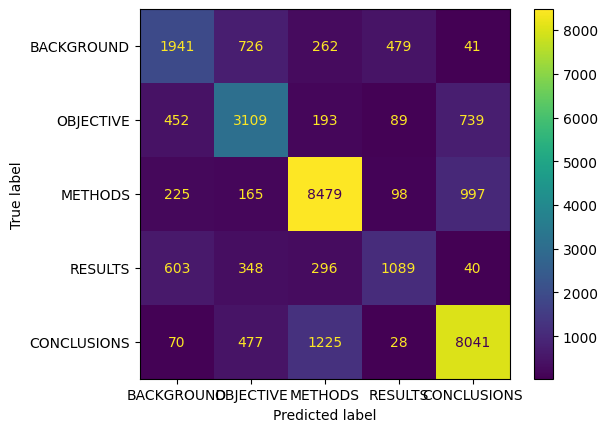

In [44]:
cm_display =ConfusionMatrixDisplay(confusion_matrix = cm,display_labels=class_names)

cm_display.plot();


In [45]:
from sklearn.metrics import accuracy_score,precision_recall_fscore_support
def calc_results(y_true,y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary
  classification model.
  """

  #Classification model accuracy
  model_accuracy=accuracy_score(y_true,y_pred)*100
  #Calc the model precision recall and f1 score 
  model_precision,model_recall,model_f1score, _ =precision_recall_fscore_support(y_true,y_pred,average="weighted")
  return {"accuracy":model_accuracy,
              "precision":model_precision,
              "recall":model_recall,
              "f1-score":model_f1score}

In [46]:
baseline_results=calc_results(val_labels_encoded,model_0_preds)
baseline_results

{'accuracy': 75.0,
 'precision': 0.7462507456606671,
 'recall': 0.75,
 'f1-score': 0.7470089677530097}

###Preparing the embedding layer for upcoming models

We need to convert the tokenized sentences into word embeddings,inorder to make accurate predictions on then through different models!

In [47]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np

In [48]:
sent_len=[len(i.split()) for i in train_sentences]
avg_sent_len=np.mean(sent_len)
sent_len[:5],avg_sent_len

([21, 28, 25, 59, 16], 26.178463580554173)

(array([2.1221e+04, 7.9010e+03, 8.5300e+02, 1.2700e+02, 2.3000e+01,
        8.0000e+00, 2.0000e+00]),
 array([  1.,  31.,  61.,  91., 121., 151., 181., 211.]),
 <BarContainer object of 7 artists>)

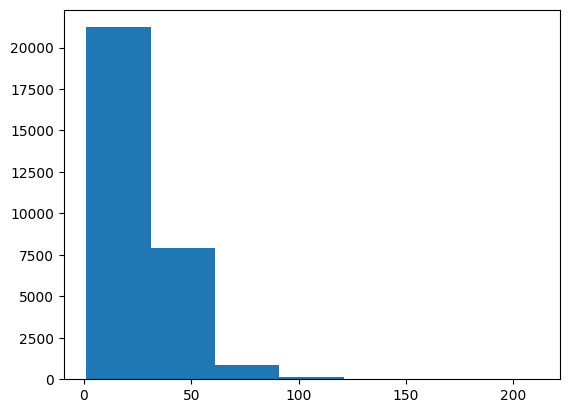

In [49]:
##Check the distribution of the sentence here
plt.hist(sent_len,bins=7)

In [50]:
##SO here most of the data is b/w the 0 anf 50
#to get the seq len we will see the val that covers 95 percent of value!
output_seq_len=int(np.percentile(sent_len,95))
output_seq_len

55

###But first we need to make an text vectorization layer of vocab size 68k (mentioned in the PAPER)

to convert words to numberd

In [51]:
###Creating an embedding layer and text vectorization layer
text_vectorizer=layers.TextVectorization(max_tokens=68000, #dictionary size
                                         standardize='lower_and_strip_punctuation',
                                         split='whitespace',
                                         output_mode='int',
                                         pad_to_max_tokens=True,
                                         output_sequence_length=output_seq_len)


In [52]:
#adapt==fit
text_vectorizer.adapt(train_sentences)


In [53]:
words_in_vocab=text_vectorizer.get_vocabulary()
words_in_vocab[:5] #Most used


['', '[UNK]', 'the', 'and', 'of']

In [54]:
words_in_vocab[-5:] #least used

['aarhus', 'aai', 'aagg', 'aadenosine', 'aacr']

In [55]:
# ##Test out the vectorizer on random sentences
# import random
# target_sentence=random.randint()

In [70]:
#Creating an embedding layer
embedding=layers.Embedding(input_dim=10000,
                           output_dim=512,
                           mask_zero=True, #Handles variable length inputs (helps to do efficient computing when there are lots of 0s)
                          #  input_length=21,
                          )

In [74]:
#A example
x=text_vectorizer(train_sentences[0])
ex=embedding(x)
print(f"the sentence is: \n{train_sentences[0]} \n\n the vectorized sentence is:\n{x} \n\n the embedded sentence is : \n{ex}")
print(f"\nShape of the embedding is :{ex.shape}")

the sentence is: 
this study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( adhf ) . 

 the vectorized sentence is:
[  23   17  422  729  164 2392    5  234  301   12 1493    7  341  223
 6863  234  301 6991    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0] 

 the embedded sentence is : 
[[ 0.00923283 -0.01513243 -0.04817538 ...  0.015695   -0.04685595
  -0.02574476]
 [-0.011352    0.00202455 -0.01120468 ... -0.01892169  0.04964292
  -0.02565161]
 [ 0.02779562 -0.01442205  0.04860617 ...  0.02560034  0.00753073
  -0.00620341]
 ...
 [ 0.03232643  0.00111546 -0.02276886 ...  0.03792938 -0.04052008
  -0.00843852]
 [ 0.03232643  0.00111546 -0.02276886 ...  0.03792938 -0.04052008
  -0.00843852]
 [ 0.03232643  0.00111546 -0.02276886 ...  0.03792938 -0.04052008
  -0.00843852]]

Shape 

In [75]:
#COngif of text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': True,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 24854}

##Creating datasets(to load data as fast as possible)

We're going to setuo daat to run as fast as possible with the Tensorflow t.data API , many of the steps here are discussed at length in these 2 resources 

###Model 1: The conv1D layer

In [59]:
inputs=layers.Input(shape=(1,),dtype=tf.string)
x=text_vectorizer(inputs)
x=embedding(x)
x=layers.Conv1D(filters=64,kernel_size=5)(x)
x=layers.GlobalMaxPooling1D()(x)
outputs=layers.Dense(5,activation="softmax")(x)

model_1=tf.keras.Model(inputs,outputs,name="model_1_conv1d")


model_1.compile(optimizer=tf.keras.optimizers.Adam(),
                loss="categorical_crossentropy",
                metrics=["accuracy"])

In [60]:
model_1.summary()

Model: "model_1_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 55, 512)           5120000   
                                                                 
 conv1d (Conv1D)             (None, 51, 64)            163904    
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 5)              

In [61]:
!wget https://github.com/mrdbourke/tensorflow-deep-learning/raw/main/extras/helper_functions.py

--2023-06-10 14:43:36--  https://github.com/mrdbourke/tensorflow-deep-learning/raw/main/extras/helper_functions.py
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py [following]
--2023-06-10 14:43:36--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-06-10 14:43:36 (96.1 MB/s) - ‘helper_func

In [62]:
from helper_functions import create_tensorboard_callback

In [63]:

import numpy as np
SAVE_DIR="model_logs"

In [64]:
model_1.fit(x=np.array(train_sentences),
            y=train_labels_encoded,
            epochs=5,
            validation_data=(np.array(val_sentences),val_labels_encoded),
            callbacks=[create_tensorboard_callback(SAVE_DIR,"model_1_Conv1D")])

Saving TensorBoard log files to: model_logs/model_1_Conv1D/20230610-144336
Epoch 1/5


ValueError: ignored

In [ ]:
len(class_names)

In [ ]:
np.array(train_sentences).shape